# Mandatory Assignment 1

#### Part I: Multi-layer Perceptron

***

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [material/nns_pytorch.ipynb](material/nns_pytorch.ipynb)

Table of contents:
1. Activate GPU
2. Load data
3. Inspect data
4. Artificial neural network (**Where you will implement the ANN**)
5. Training hyperparameters (**Where you will add training parameters**)
6. Training
7. Plot loss and accuracy
8. Evaluate


In [1]:
# auxilary imports
import random
import matplotlib.pyplot as plt
import os
from pathlib import Path

# pytorch
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F  # noqa

First, a bit of a hack in case your IDE wants to run the notebook from /`assignment/` and not the project root folder `/ma1`. We need the working directory to be `/ma1` for local imports to work.

In [2]:
# Ensure the working directory is set to the "ma1" folder.
while Path.cwd().name != "ma1" and "ma1" in str(Path.cwd()):
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: /Users/isimisi/Documents/AIML25/mas/ma1


##### Import local files

To declutter the notebooks, your are given a module (`/src`) of useful functions. Please study each one as they contain important code (particularly `src.training` and `src.evaluation`). 

In [3]:
# local files
from src.utils import get_device
from src.data import load_torch_data, to_dataloader, train_val_split
from src.training import fit
from src.evaluation import evaluate
from src.visualize import plot_training_history

### 1. Activate GPU
If available. Note that this is not necessary, but it will speed up your training.

In [4]:
# Device will determine whether to run the training on GPU or CPU.
DEVICE = get_device()

Running pytorch version (2.5.1) with backend = mps


### 2. Load data

In [5]:
# load the training/validation data
train_val = load_torch_data(
    dataset="MNIST",
    root = 'data',                     # The root directory where the dataset will be stored
    download = True,                   # If the dataset is not found at root, it will be downloaded
    train = True,                      # The train dataset (as opposed to the test dataset)
    transform = transforms.ToTensor()  # transformations to be applied to the dataset (only cast to tensor)
)

# load the testing data
test = load_torch_data(
    dataset = "MNIST",
    root = 'data',
    download = True,
    train = False,
    transform = transforms.ToTensor()
)

f"{len(train_val)=}, {len(test)=}"

'len(train_val)=60000, len(test)=10000'

In [6]:
# split training data in training and validation (just like train_test_split in sklearn)
train, val = train_val_split(train_val, val_ratio=0.2, seed=42)

f"{len(val)=}, {len(train)=}"

'len(val)=12000, len(train)=48000'

In [7]:
# create dataloders for easy batch loading during training
train_loader = to_dataloader(train, batch_size = 64, shuffle = True)
val_loader = to_dataloader(val, batch_size = 64, shuffle = False)
test_loader = to_dataloader(test, batch_size = 64, shuffle = False)

### 3. Inspect data

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
Total pixels: 784
The label for this image: 6


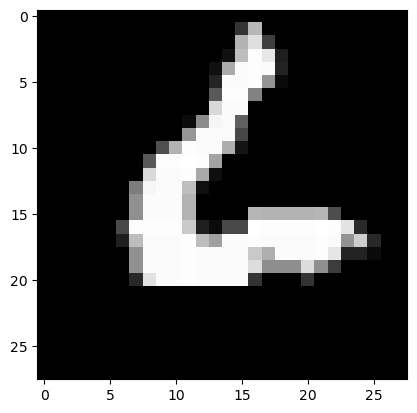

In [8]:
# Pick a random example from the training set
selection = random.randrange(len(train)-1)
image, label = train[selection]

# Plot the image
print(f"Default image shape: {image.shape}")
image = image.view([28,28])

print(f"Reshaped image shape: {image.shape}")
plt.imshow(image, cmap="gray")

print(f"Total pixels: {image.shape[0] * image.shape[1]}")

# Print the label
print(f"The label for this image: {label}")


***

### 4. Artificial neural network

In [9]:
class MLP_Base(nn.Module):

  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(28 * 28, 500)

    # We have 10 diferent classes (0 - 9), that's why the number of output neurons are 10
    self.fc2 = nn.Linear(500, 10)
    self.relu = nn.ReLU()

  def forward(self, x : torch.Tensor):

    x = self.relu(self.fc1(x))
    x = self.fc2(x) 

    return x

The above illustrates what were shown in the workshop, which gained an accuracy of around **95%** with a `learning rate = 0.01` and the `number of epochs = 30`

This will be used as a base case for my experimentation of the architecture. My goal is to make an architecture that will give a better result.

In [44]:
class MLP_CE(nn.Module):
    def __init__(self):
        super().__init__()

        pixels_in_img = 28 * 28

        self.fc1 = nn.Linear(pixels_in_img, pixels_in_img * 2)
        self.fc2 = nn.Linear(pixels_in_img * 2, 500)
        self.fc3 = nn.Linear(500, 10)

        self.relu = nn.ReLU()

    def forward(self, x : torch.Tensor):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [99]:
class MLP_Funnel(nn.Module):
    def __init__(self):
        super().__init__()

        pixels_in_img = 28 * 28

        self.fc1 = nn.Linear(pixels_in_img, 600)
        self.fc2 = nn.Linear(600, 500)
        self.fc3 = nn.Linear(500, 300)
        self.fc4 = nn.Linear(300, 10)

        self.relu = nn.ReLU()

    def forward(self, x : torch.Tensor):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        return x

### 5. Training hyperparameters

In [97]:
# How large "steps" the algorithm should take
LR = 0.01  

# How many times we should run through our data, for the model to learn all signals
NUM_EPOCHS = 50 

criterion = nn.CrossEntropyLoss()  # The loss function

Instantiate the model and optimizer

In [100]:
model = MLP_Funnel().to(DEVICE)   # Create an instance of the MLP model and move it to device (GPU or CPU)
optimizer = torch.optim.SGD(model.parameters(), lr=LR) # The optimizer (here, SGD - you can also try ADAM)

In [101]:
model

MLP_Funnel(
  (fc1): Linear(in_features=784, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=10, bias=True)
  (relu): ReLU()
)

### 6. Training

In [102]:
model, history = fit(
    model,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    optimizer = optimizer,
    criterion = criterion,
    num_epochs = NUM_EPOCHS
)

Epoch [1/50]: Train Loss: 2.2187 | Train Accuracy: 43.25% | Val Loss: 1.9669 | Val Accuracy: 55.96%
Epoch [2/50]: Train Loss: 1.0806 | Train Accuracy: 74.48% | Val Loss: 0.5975 | Val Accuracy: 83.17%
Epoch [3/50]: Train Loss: 0.4842 | Train Accuracy: 86.34% | Val Loss: 0.4310 | Val Accuracy: 87.92%
Epoch [4/50]: Train Loss: 0.3829 | Train Accuracy: 89.13% | Val Loss: 0.3741 | Val Accuracy: 89.56%
Epoch [5/50]: Train Loss: 0.3370 | Train Accuracy: 90.52% | Val Loss: 0.3434 | Val Accuracy: 90.32%
Epoch [6/50]: Train Loss: 0.3047 | Train Accuracy: 91.39% | Val Loss: 0.3141 | Val Accuracy: 91.03%
Epoch [7/50]: Train Loss: 0.2791 | Train Accuracy: 92.01% | Val Loss: 0.2915 | Val Accuracy: 91.72%
Epoch [8/50]: Train Loss: 0.2556 | Train Accuracy: 92.69% | Val Loss: 0.2719 | Val Accuracy: 92.53%
Epoch [9/50]: Train Loss: 0.2353 | Train Accuracy: 93.19% | Val Loss: 0.2499 | Val Accuracy: 92.91%
Epoch [10/50]: Train Loss: 0.2157 | Train Accuracy: 93.84% | Val Loss: 0.2397 | Val Accuracy: 92.94%

### 7. Plot loss and accuracy

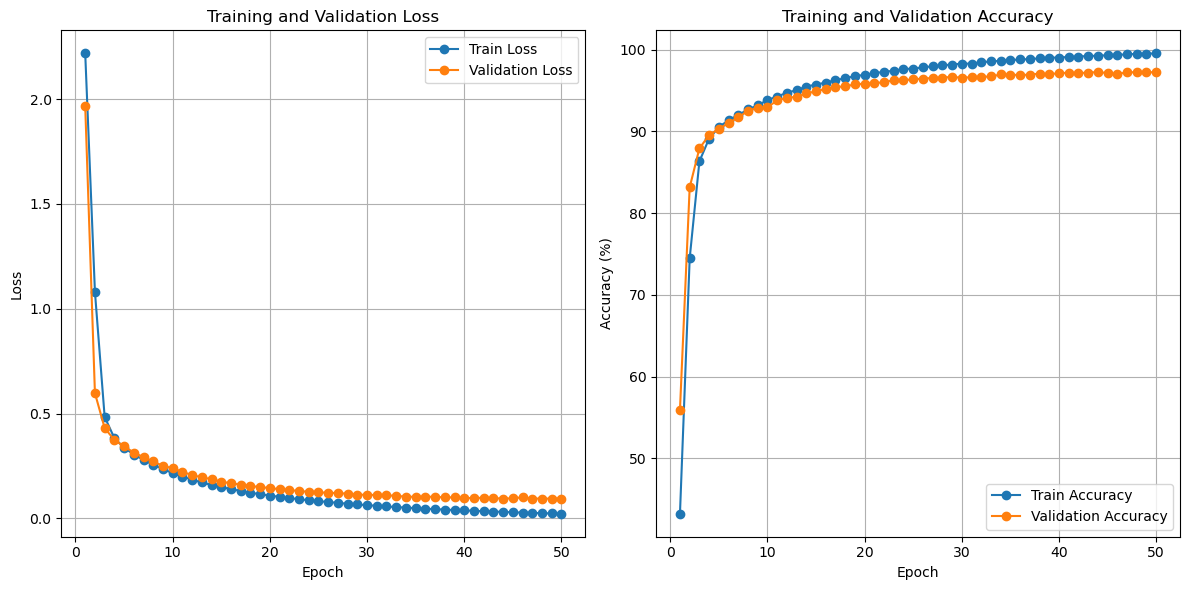

In [103]:
plot_training_history(history)

# if the curve hasn't flattened out - it means we havn't hit a minimum yet => we need to keep training
# We can also add more neurons in our hidden layer, and tune our hyperparamters (learning rate)

### 8. Evaluate

In [104]:
evaluate(
    model = model,
    data_loader = train_loader,  # evaluate on training data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.0198, Accuracy: 99.67%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4735
           1       1.00      1.00      1.00      5383
           2       1.00      1.00      1.00      4762
           3       1.00      1.00      1.00      4886
           4       0.99      1.00      1.00      4681
           5       1.00      1.00      1.00      4368
           6       1.00      1.00      1.00      4752
           7       1.00      1.00      1.00      4983
           8       1.00      0.99      1.00      4674
           9       1.00      0.99      0.99      4776

    accuracy                           1.00     48000
   macro avg       1.00      1.00      1.00     48000
weighted avg       1.00      1.00      1.00     48000



In [105]:
evaluate(
    model = model,
    data_loader = val_loader,  # evaluate on validation data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.0945, Accuracy: 97.24%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1188
           1       0.98      0.99      0.99      1359
           2       0.97      0.97      0.97      1196
           3       0.96      0.97      0.97      1245
           4       0.97      0.98      0.97      1161
           5       0.96      0.97      0.97      1053
           6       0.98      0.98      0.98      1166
           7       0.98      0.98      0.98      1282
           8       0.98      0.96      0.97      1177
           9       0.96      0.95      0.96      1173

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



In [106]:
evaluate(
    model = model,
    data_loader = test_loader,  # evaluate on testing data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.0786, Accuracy: 97.64%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### 9. Results

Result where
- `NUM_EPOCHS = 30`
- `LR = 0.01`

|                  | Base  | Expansion Contraction | Funnel |
|------------------|-------|-----------------------|--------|
| Train score      |95.91% | 97.70%           	   | 98.36% |
| Validation score |94.79% | 96.39%                | 96.68% |

While `MLP_Funnel` had best validation and train score, the learning curve looked a lot more flattened out than the other two models.

I then tried to tune the hyperparamethers `NUM_EPOCHS` and `LR` to see if that would change the results.

Results where
- `NUM_OF_EPOCHS = 50`
- `LR = 0.01`

|                  | Base  | Expansion Contraction | Funnel |
|------------------|-------|-----------------------|--------|
| Train score      |97.27% | 98.97%           	   | 99.69% |
| Validation score |96.56% | 97.13%                | 97.28% |

Still the best performing model is the Funnel model, however the Funnel model's learning curve has flattened out to be almost horizontal. Whereas the base model's curve does not seem to be flatting out, and the EC model is just starting to flatten out. 

Next I will try to adjust the learning rate, to compare results.

Results where
- `NUM_OF_EPOCHS = 50`
- `LR = 0.005`

|                  | Base  | Expansion Contraction | Funnel |
|------------------|-------|-----------------------|--------|
| Train score      |95.21% | 97.16%           	   | 97.81% |
| Validation score |94.32% | 95.75%                | 96.27% |

This configration proved to be the worst configuration yet, instead I will now try to increase the learning rate.

Results where
- `NUM_OF_EPOCHS = 50`
- `LR = 0.05`

|                  | Base  | Expansion Contraction | Funnel |
|------------------|-------|-----------------------|--------|
| Train score      |99.88% | 100.00%           	   |100.00% |
| Validation score |97.67% | 97.82%                | 97.78% |

This configuration seems to have created overfit models, as the train score is 100.00% on both the EC model and the Funnel model.

### 10. Conclusion

The best configration were, where:
- `NUM_OF_EPOCHS = 50`
- `LR = 0.01`

And the model with the best resutls where the `MLP_Funnel`.

Lastly we look at the test score, to give it a final evaluation.

|                  | Funnel |
|------------------|--------|
| Train score      | 99.67% |
| Validation score | 97.24% |
| Test score       | 97.64% |

